### Hybrid Quantum GAN

This notebook shows how to build and train a Hybrid quantum GAN. The hyrid QGAN has a classical discriminator network while quantum circuit acts as generator

The generator and discriminator are trained adversarily.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch
from scipy.stats import multivariate_normal
from torch import nn
from IPython.display import clear_output
import time
from scipy.stats import multivariate_normal, entropy
from torch.optim import Adam


plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Data

We specify the disctribution we want to learn. In this case we take a discrete gaussian with values from $[0,15]$, where $\mu=7$ and $\sigma^2=1.5$.

In order to learn the distribution from data, we sample $N=20000$ samples from our distribution.

In [2]:
num_discrete_values = 16
num_qubits = int(np.log2(num_discrete_values))

N = 20000
nbatch = 2000

reg = 0.000001

I plot the normalized abundance of each state in the dataset, and save it as `prob_data`. This will later act as reference distribution to compare our generated distribution to.

In [3]:
grid_elements = np.arange(0, 16)
data = np.random.normal(7,1.5,N).astype(int)

values, counts = np.unique(data, return_counts=True)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

idx = np.argsort(values)

values = values[idx]
counts = counts[idx]

prob_data = counts/N

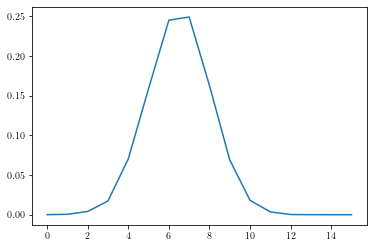

In [4]:
plt.plot(prob_data)
plt.show()

## Model

To build the model we first define the quantum circuit, which simply consists of an arbitrary initialization and a parametrized strong entangling layer.
Note that we use the `default.qubit.torch` device to implement backpropagation with our pytorch hybrid architecture.

The Qnode returns the full set of probabilities of the basis states.

Note that I define an `inputs` argument to the Qnode.
**This is not used!** Our generator does not get any input. However we need an input to define a Torch layer.

In [5]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    #for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.probs()

/tmp/ipykernel_134689/4138310346.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


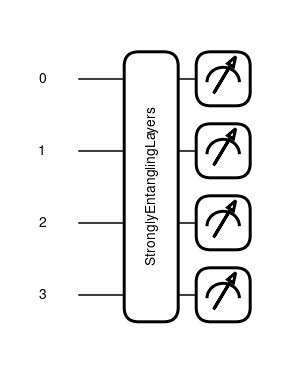

In [6]:
fig, ax = qml.draw_mpl(circuit)(1,np.zeros(shape=(2,num_qubits,3)))
fig.show()

Instead of sampling the states to evaluate our loss function at, we can also sample them from the generator distribution. In my experiments this did stabelize the training, however it lead to worse convergence.

If we want to sample from the generator, we will have to define a Qnode which does the respective measurement.

In [7]:
dev_sample = qml.device("default.qubit", wires=num_qubits, shots=nbatch)

@qml.qnode(dev_sample, interface="torch")
def circuit_sample(inputs, weights):
    #for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.sample(wires=[0,1,2,3])

To build the quantum layer for the hybrid architecture, we define the weights of the quantum circuit and convert the circuit to a pytorch layer

In [8]:
n_layers=8
weight_shapes = {"weights": (n_layers, num_qubits,3)}

In [9]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

The discriminator is just a simple fully connected network which takes the input and has a single output neuron.

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        
        super(Discriminator, self).__init__()
        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        
        x = self.linear_input(inputs)
        x = self.leaky_relu(x)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

We define the generator as the quantum layer and the discriminator as the fully connected network

In [11]:
generator = qlayer
discriminator = Discriminator(1)

We define the loss function for samples that should be learned to be true or false respectively

In [12]:
def loss_true(inputs, w):
    loss = w * torch.log(inputs + reg)
    return -torch.sum(loss)

def loss_false(inputs, w):
    loss = w * torch.log(1 - inputs)
    return -torch.sum(loss)

In addition we define some utility functions for the training

In [13]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training(n, samples_tuple):
    
    clear_output(wait=True)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    fig.tight_layout(pad=6.0)

    ax3.plot(generator_loss_hist, label="generator loss")
    ax3.plot(discriminator_loss_hist, label="discriminator loss")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)

    ax2.plot(KL_div_hist)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    
    paramsg = generator.weights
    generated_probabilities = circuit(1,paramsg).detach()
    ax1.plot(generated_probabilities, label="generated")
    ax1.plot(prob_data,label="real")
    ax1.legend(loc="upper right", fontsize=18)
    ax1.set_xlabel("$i$", fontsize=18)
    ax1.set_ylabel("$P_i$", fontsize=18)

    ax4.plot(discriminator(torch.tensor(list(range(16))).reshape(16,1).float()).detach())
    ax4.set_xlabel("$i$", fontsize=18)
    ax4.set_ylabel("$D(i)$", fontsize=18)
    
    for samples in samples_tuple:
        values, counts = np.unique(samples, return_counts=True)
        if (values == np.arange(0,16)).all(): ax5.plot(counts)
    ax5.set_xlabel("i")
    ax5.set_ylabel("sample distribution")
        

    plt.show()

In [14]:
def tensor_to_int(tensor):
    tensor = tensor.long()
    
    # Calculate the number of columns in the tensor
    num_columns = tensor.size(1)
    
    # Create a weight tensor for binary to integer conversion
    weights = 2 ** torch.arange(num_columns - 1, -1, -1)
    
    # Calculate the integer values for each row
    int_values = torch.sum(tensor * weights, dim=1)
    
    return int_values

In [15]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

Now we are ready to define our training parameters

In [16]:
n_epochs = 2000
lr = 0.0001
b1 = 0.7   
b2 = 0.999 
decayRate = 0.9999
generator_sampling = False

gen_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True)
disc_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True
)

gen_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=gen_optimizer, gamma=decayRate)
disc_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=disc_optimizer, gamma=decayRate)

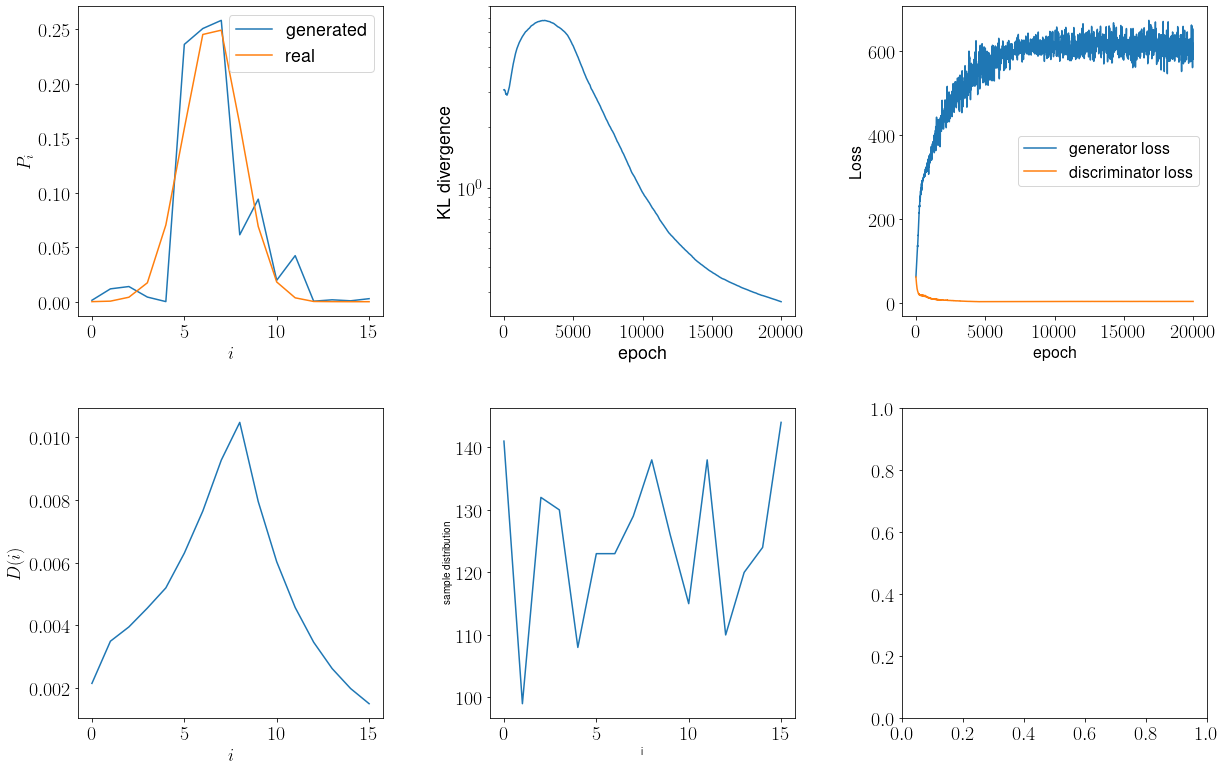

Fit in 25006.80 sec


In [17]:
#torch.nn.init.uniform_(list(generator.parameters())[0], a=-0.1, b=0.1)
torch.nn.init.uniform_(list(generator.parameters())[0], a=-np.pi, b=np.pi)

data = torch.tensor(data, requires_grad=False)

generator_loss_hist = []
discriminator_loss_hist = []
KL_div_hist = []

start = time.time()
for epoch in range(n_epochs):

    if generator_sampling:
        samples = tensor_to_int(circuit_sample(1, list(generator.parameters())[0].detach()))
    else:
        samples = torch.tensor(np.random.randint(0,16, size=(nbatch,)), dtype=torch.float).reshape(nbatch,1)
    
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=nbatch)):
    
        disc_vals = discriminator(samples)
    
        gen_dist = generator(torch.tensor([]))

        # Generator training step
        gen_optimizer.zero_grad()
        gen_loss = loss_true(disc_vals.detach().reshape(-1), gen_dist[samples.long().reshape(-1)])

        generator_loss_hist.append(gen_loss.detach().item())

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()

        # Discriminator training step
        disc_optimizer.zero_grad()
     
        real_disc_vals = discriminator(Xbatch.float().reshape(-1,1))
    
        true_loss = loss_true(real_disc_vals.reshape(-1), torch.tensor(np.ones(nbatch)*1/nbatch, requires_grad=False))
        false_loss = loss_false(disc_vals.reshape(-1), gen_dist.detach()[samples.long().reshape(-1)])
        disc_loss = (true_loss + false_loss) / 2

        # Store for plotting
        discriminator_loss_hist.append(disc_loss.detach().item())

        disc_loss.backward()
        disc_optimizer.step()
        
        KL_div = entropy(gen_dist.detach().squeeze().numpy()+reg, prob_data+reg)
        KL_div_hist.append(KL_div)

        gen_lr_scheduler.step()
        disc_lr_scheduler.step()
    
        plot_training(epoch, (samples,))
    
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")